Реализовать с помощью `Numpy` класс `MyMLP`, моделирующий работу полносвязной нейронной сети.

Реализуемый класс должен

1. Поддерживать создание любого числа слоев с любым числом нейронов. Тип инициализации весов не регламентируется.
2. Обеспечивать выбор следующих функции активации в рамках каждого слоя: `ReLU`, `sigmoid`, `linear`.
3. Поддерживать решение задачи классификации и регрессии (выбор соответствующего лосса, в том числе для задачи многоклассовой классификации).
4. В процессе обучения использовать самостоятельно реализованный механизм обратного распространения (вывод формул в формате markdown) для применения градиентного и стохастического градиентного спусков (с выбором размера батча)
5. Поддерживать использование `l1`, `l2` и `l1l2` регуляризаций.

Самостоятельно выбрать наборы данных (классификация и регрессия). Провести эксперименты (различные конфигурации сети: количество слоев, нейронов, функции активации, скорость обучения и тп. — минимум 5 различных конфигураций) и сравнить результаты работы (оценка качества модели + время обучения и инференса) реализованного класса `MyMLP` со следующими моделям (в одинаковых конфигурациях):

*   MLPClassifier/MLPRegressor из sklearn
*   TensorFlow
*   Keras
*   PyTorch

Результат представить в виде .ipynb блокнота, содержащего весь необходимый код и визуализации сравнения реализаций для рассмотренных конфигураций.


In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:


class MyMLPLayer:
    def __init__(self, input_size, output_size, activation):
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2. / input_size)  # He initialization
        self.biases = np.zeros((1, output_size))
        self.activation_name = activation

    def activate(self, x):
        if self.activation_name == 'relu':
            return np.maximum(0, x)
        elif self.activation_name == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation_name == 'linear':
            return x
        elif self.activation_name == 'softmax':
            exps = np.exp(x - np.max(x, axis=1, keepdims=True))
            return exps / np.sum(exps, axis=1, keepdims=True)

    def activation_derivative(self, x):
        if self.activation_name == 'relu':
            return (x > 0).astype(float)
        elif self.activation_name == 'sigmoid':
            sig = 1 / (1 + np.exp(-x))
            return sig * (1 - sig)
        elif self.activation_name == 'linear':
            return np.ones_like(x)
        elif self.activation_name == 'softmax':
            # For softmax, this is not used directly in backprop
            return np.ones_like(x)

class MyMLP:
    def __init__(self, layers_config, learning_rate=0.01, task='classification', loss='cross_entropy',
                 reg=None, reg_lambda=0.0):
        self.layers = []
        for i in range(len(layers_config) - 1):
            input_size = layers_config[i][0]
            output_size = layers_config[i+1][0]
            activation = layers_config[i+1][1]

            # For classification, last layer should be softmax if cross_entropy
            if i == len(layers_config)-2 and task == 'classification' and loss == 'cross_entropy':
                activation = 'softmax'

            self.layers.append(MyMLPLayer(input_size, output_size, activation))

        self.learning_rate = learning_rate
        self.task = task
        self.loss_name = loss
        self.reg = reg
        self.reg_lambda = reg_lambda

    def _loss(self, y_true, y_pred):
        m = y_true.shape[0]
        if self.loss_name == 'cross_entropy':
            eps = 1e-15
            y_pred = np.clip(y_pred, eps, 1 - eps)
            return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        elif self.loss_name == 'mse':
            return np.mean((y_true - y_pred) ** 2)

    def _loss_derivative(self, y_true, y_pred):
        if self.loss_name == 'cross_entropy':
            # For softmax + cross_entropy, the derivative is simply y_pred - y_true
            return y_pred - y_true
        elif self.loss_name == 'mse':
            return 2 * (y_pred - y_true) / y_true.shape[0]

    def _apply_regularization(self, grad_w, weights):
        if self.reg == 'l1':
            return grad_w + self.reg_lambda * np.sign(weights)
        elif self.reg == 'l2':
            return grad_w + 2 * self.reg_lambda * weights
        elif self.reg == 'l1l2':
            return grad_w + self.reg_lambda * np.sign(weights) + 2 * self.reg_lambda * weights
        else:
            return grad_w

    def forward(self, X):
        activations = [X]
        pre_activations = []
        a = X
        for layer in self.layers:
            z = np.dot(a, layer.weights) + layer.biases
            a = layer.activate(z)
            pre_activations.append(z)
            activations.append(a)
        return activations, pre_activations

    def backward(self, activations, pre_activations, y_true):
        grads = []
        m = y_true.shape[0]

        # Output layer
        delta = self._loss_derivative(y_true, activations[-1])

        # For softmax activation in output layer, we don't multiply by activation derivative
        if self.layers[-1].activation_name != 'softmax':
            delta *= self.layers[-1].activation_derivative(pre_activations[-1])

        for i in reversed(range(len(self.layers))):
            a_prev = activations[i]
            dw = np.dot(a_prev.T, delta) / m
            db = np.sum(delta, axis=0, keepdims=True) / m
            dw = self._apply_regularization(dw, self.layers[i].weights)

            grads.insert(0, (dw, db))

            if i > 0:
                delta = np.dot(delta, self.layers[i].weights.T) * \
                        self.layers[i-1].activation_derivative(pre_activations[i-1])

        return grads

    def update_params(self, grads):
        for i, (dw, db) in enumerate(grads):
            self.layers[i].weights -= self.learning_rate * dw
            self.layers[i].biases -= self.learning_rate * db

    def fit(self, X, y, epochs=100, batch_size=32, verbose=False):
        m = X.shape[0]
        for epoch in range(epochs):
            indices = np.arange(m)
            np.random.shuffle(indices)
            for i in range(0, m, batch_size):
                batch_end = min(i + batch_size, m)
                X_batch = X[indices[i:batch_end]]
                y_batch = y[indices[i:batch_end]]

                activations, pre_activations = self.forward(X_batch)
                grads = self.backward(activations, pre_activations, y_batch)
                self.update_params(grads)

            if verbose and epoch % 10 == 0:
                activations, _ = self.forward(X)
                loss = self._loss(y, activations[-1])
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        activations, _ = self.forward(X)
        output = activations[-1]
        if self.task == 'classification':
            return np.argmax(output, axis=1)
        else:
            return output

    def evaluate(self, X, y):
        pred = self.predict(X)
        if self.task == 'classification':
            true = np.argmax(y, axis=1)
            return np.mean(pred == true)
        else:
            return np.mean((pred - y) ** 2)

## Теория: Прямой и обратный проход в `MyMLP`

---

### **1. Прямой проход (Forward pass)**

Для каждого слоя $l$ с входом $A^{(l-1)}$, весами $W^{(l)}$, смещением $b^{(l)}$:

$$
Z^{(l)} = A^{(l-1)} W^{(l)} + b^{(l)}
$$

$$
A^{(l)} = f(Z^{(l)})
$$

где $f \in \{ \text{ReLU}, \text{Sigmoid}, \text{Linear} \}$

---

### **2. Функции активации**

- **ReLU**:
  $$
  f(z) = \max(0, z), \quad f'(z) =
  \begin{cases}
  1, & z > 0 \\
  0, & z \leq 0
  \end{cases}
  $$

- **Sigmoid**:
  $$
  f(z) = \frac{1}{1 + e^{-z}}, \quad f'(z) = f(z)(1 - f(z))
  $$

- **Linear**:
  $$
  f(z) = z, \quad f'(z) = 1
  $$

---

### **3. Функции потерь**

- **Классификация (Cross-Entropy)**:
  $$
  \mathcal{L} = -\frac{1}{m} \sum_{i=1}^m \sum_{k=1}^{K} y_{ik} \log(\hat{y}_{ik})
  $$

- **Регрессия (MSE)**:
  $$
  \mathcal{L} = \frac{1}{m} \sum_{i=1}^m (y_i - \hat{y}_i)^2
  $$

---

### **4. Обратное распространение ошибки (Backpropagation)**

Пусть:

- $\delta^{(l)}$ — градиент ошибки на слое $l$
- $\eta$ — скорость обучения
- $m$ — размер батча
- $\lambda$ — коэффициент регуляризации

#### Выходной слой:

- **Регрессия (MSE)**:
  $$
  \delta^{(L)} = 2(\hat{y} - y) \cdot f'(Z^{(L)})
  $$

- **Классификация (Softmax + Cross-Entropy)**:
  $$
  \delta^{(L)} = \hat{y} - y
  $$

#### Скрытые слои $l = L-1, \dots, 1$:

$$
\delta^{(l)} = \left( \delta^{(l+1)} {W^{(l+1)}}^T \right) \cdot f'(Z^{(l)})
$$

---

### **5. Обновление весов (Gradient Descent + Regularization)**

#### Без регуляризации:

$$
W^{(l)} := W^{(l)} - \eta \cdot \frac{1}{m} {A^{(l-1)}}^T \delta^{(l)}
$$

#### L1-регуляризация:

$$
W^{(l)} := W^{(l)} - \eta \left( \frac{1}{m} {A^{(l-1)}}^T \delta^{(l)} + \lambda \cdot \text{sign}(W^{(l)}) \right)
$$

#### L2-регуляризация:

$$
W^{(l)} := W^{(l)} - \eta \left( \frac{1}{m} {A^{(l-1)}}^T \delta^{(l)} + 2\lambda W^{(l)} \right)
$$

#### L1 + L2 (Elastic Net):

$$
W^{(l)} := W^{(l)} - \eta \left( \frac{1}{m} {A^{(l-1)}}^T \delta^{(l)} + \lambda \left( \text{sign}(W^{(l)}) + 2W^{(l)} \right) \right)
$$

Аналогично обновляются смещения $b^{(l)}$:

$$
b^{(l)} := b^{(l)} - \eta \cdot \text{mean}(\delta^{(l)})
$$


## Эксперименты

In [3]:
import numpy as np
import pandas as pd
import time
from sklearn.datasets import load_iris, load_diabetes, fetch_california_housing, make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [5]:
# Классификация — Iris
iris = load_iris()
X_class, y_class = iris.data, iris.target
X_class = StandardScaler().fit_transform(X_class)
y_class_oh = OneHotEncoder(sparse_output=False).fit_transform(y_class.reshape(-1, 1))
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_class, y_class_oh, test_size=0.2, random_state=42)

In [6]:
configs = [
    {'layers': [(4,), (10, 'relu'), (3, 'softmax')], 'lr': 0.01},
    {'layers': [(4,), (16, 'relu'), (16, 'relu'), (3, 'softmax')], 'lr': 0.005},
    {'layers': [(4,), (8, 'sigmoid'), (3, 'softmax')], 'lr': 0.01},
    {'layers': [(4,), (20, 'relu'), (10, 'sigmoid'), (3, 'softmax')], 'lr': 0.001},
    {'layers': [(4,), (32, 'relu'), (32, 'relu'), (3, 'softmax')], 'lr': 0.01}
]

In [7]:
from copy import deepcopy

results = []

for config_idx, cfg in enumerate(configs):
    print(f"\nКонфигурация #{config_idx+1}")
    print("Архитектура:", cfg['layers'])
    print("Learning rate:", cfg['lr'])

    # MyMLP
    try:
        mymlp = MyMLP(deepcopy(cfg['layers']), learning_rate=cfg['lr'],
                     task='classification', loss='cross_entropy')

        # Обучение
        t0 = time.time()
        mymlp.fit(Xc_train, yc_train, epochs=100, batch_size=16)
        t1 = time.time()
        my_train_time = t1 - t0

        # Инференс
        t0_inf = time.time()
        my_acc = mymlp.evaluate(Xc_test, yc_test)
        t1_inf = time.time()
        my_inf_time = t1_inf - t0_inf

        print(f"MyMLP Accuracy: {my_acc:.4f}, Train Time: {my_train_time:.2f}s, Inference Time: {my_inf_time:.4f}s")
    except Exception as e:
        print(f"MyMLP failed: {str(e)}")
        my_acc, my_train_time, my_inf_time = np.nan, np.nan, np.nan

    # Sklearn
    try:
        hidden_layers = tuple(layer[0] for layer in cfg['layers'][1:-1])
        sk_mlp = MLPClassifier(hidden_layer_sizes=hidden_layers,
                             activation='relu',
                             learning_rate_init=cfg['lr'],
                             max_iter=100,
                             random_state=42)

        # Обучение
        t0 = time.time()
        sk_mlp.fit(Xc_train, np.argmax(yc_train, axis=1))
        t1 = time.time()
        sk_train_time = t1 - t0

        # Инференс
        t0_inf = time.time()
        sk_acc = sk_mlp.score(Xc_test, np.argmax(yc_test, axis=1))
        t1_inf = time.time()
        sk_inf_time = t1_inf - t0_inf

        print(f"Sklearn Accuracy: {sk_acc:.4f}, Train Time: {sk_train_time:.2f}s, Inference Time: {sk_inf_time:.4f}s")
    except Exception as e:
        print(f"Sklearn failed: {str(e)}")
        sk_acc, sk_train_time, sk_inf_time = np.nan, np.nan, np.nan

    # TensorFlow
    try:
        tf_model = Sequential()
        for i, (units, act) in enumerate(cfg['layers'][1:]):
            activation = 'softmax' if i == len(cfg['layers'])-2 else \
                       'sigmoid' if act == 'sigmoid' else \
                       'relu' if act == 'relu' else 'linear'
            tf_model.add(Dense(units, activation=activation,
                             input_dim=cfg['layers'][i][0] if i == 0 else None))
        tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=cfg['lr']),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

        # Обучение
        t0 = time.time()
        tf_model.fit(Xc_train, yc_train, epochs=100, verbose=0, batch_size=16)
        t1 = time.time()
        tf_train_time = t1 - t0

        # Инференс
        t0_inf = time.time()
        _, tf_acc = tf_model.evaluate(Xc_test, yc_test, verbose=0)
        t1_inf = time.time()
        tf_inf_time = t1_inf - t0_inf

        print(f"TensorFlow Accuracy: {tf_acc:.4f}, Train Time: {tf_train_time:.2f}s, Inference Time: {tf_inf_time:.4f}s")
    except Exception as e:
        print(f"TensorFlow failed: {str(e)}")
        tf_acc, tf_train_time, tf_inf_time = np.nan, np.nan, np.nan

    # Keras
    try:
        keras_model = Sequential()
        for i, (units, act) in enumerate(cfg['layers'][1:]):
            activation = 'softmax' if i == len(cfg['layers'])-2 else \
                       'sigmoid' if act == 'sigmoid' else \
                       'relu' if act == 'relu' else 'linear'
            keras_model.add(Dense(units, activation=activation,
                               input_dim=cfg['layers'][i][0] if i == 0 else None))
        keras_model.compile(optimizer=Adam(learning_rate=cfg['lr']),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

        # Обучение
        t0 = time.time()
        keras_model.fit(Xc_train, yc_train, epochs=100, verbose=0, batch_size=16)
        t1 = time.time()
        keras_train_time = t1 - t0

        # Инференс
        t0_inf = time.time()
        _, keras_acc = keras_model.evaluate(Xc_test, yc_test, verbose=0)
        t1_inf = time.time()
        keras_inf_time = t1_inf - t0_inf

        print(f"Keras Accuracy: {keras_acc:.4f}, Train Time: {keras_train_time:.2f}s, Inference Time: {keras_inf_time:.4f}s")
    except Exception as e:
        print(f"Keras failed: {str(e)}")
        keras_acc, keras_train_time, keras_inf_time = np.nan, np.nan, np.nan

    # PyTorch
    try:
        class TorchNet(nn.Module):
            def __init__(self, layers_cfg):
                super(TorchNet, self).__init__()
                self.layers = nn.ModuleList()
                for i in range(1, len(layers_cfg)):
                    in_dim = layers_cfg[i-1][0]
                    out_dim = layers_cfg[i][0]
                    self.layers.append(nn.Linear(in_dim, out_dim))
                    if i < len(layers_cfg)-1:
                        act = layers_cfg[i][1]
                        if act == 'relu':
                            self.layers.append(nn.ReLU())
                        elif act == 'sigmoid':
                            self.layers.append(nn.Sigmoid())

            def forward(self, x):
                for layer in self.layers:
                    x = layer(x)
                return x

        torch_model = TorchNet(cfg['layers'])
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(torch_model.parameters(), lr=cfg['lr'])

        X_train_tensor = torch.tensor(Xc_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(np.argmax(yc_train, axis=1), dtype=torch.long)
        X_test_tensor = torch.tensor(Xc_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(np.argmax(yc_test, axis=1), dtype=torch.long)

        # Обучение
        t0 = time.time()
        for epoch in range(100):
            optimizer.zero_grad()
            outputs = torch_model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()
        t1 = time.time()
        torch_train_time = t1 - t0

        # Инференс
        with torch.no_grad():
            t0_inf = time.time()
            pred = torch_model(X_test_tensor)
            _, predicted = torch.max(pred, 1)
            torch_acc = (predicted == y_test_tensor).float().mean().item()
            t1_inf = time.time()
            torch_inf_time = t1_inf - t0_inf

        print(f"PyTorch Accuracy: {torch_acc:.4f}, Train Time: {torch_train_time:.2f}s, Inference Time: {torch_inf_time:.4f}s")
    except Exception as e:
        print(f"PyTorch failed: {str(e)}")
        torch_acc, torch_train_time, torch_inf_time = np.nan, np.nan, np.nan

    # === Сбор результатов ===
    results.append({
        'Model': 'MyMLP',
        'Config': f'{config_idx+1}',
        'Accuracy': my_acc,
        'Train Time (s)': my_train_time,
        'Inference Time (s)': my_inf_time
    })
    results.append({
        'Model': 'Sklearn',
        'Config': f'{config_idx+1}',
        'Accuracy': sk_acc,
        'Train Time (s)': sk_train_time,
        'Inference Time (s)': sk_inf_time
    })
    results.append({
        'Model': 'TensorFlow',
        'Config': f'{config_idx+1}',
        'Accuracy': tf_acc,
        'Train Time (s)': tf_train_time,
        'Inference Time (s)': tf_inf_time
    })
    results.append({
        'Model': 'Keras',
        'Config': f'{config_idx+1}',
        'Accuracy': keras_acc,
        'Train Time (s)': keras_train_time,
        'Inference Time (s)': keras_inf_time
    })
    results.append({
        'Model': 'PyTorch',
        'Config': f'{config_idx+1}',
        'Accuracy': torch_acc,
        'Train Time (s)': torch_train_time,
        'Inference Time (s)': torch_inf_time
    })


Конфигурация #1
Архитектура: [(4,), (10, 'relu'), (3, 'softmax')]
Learning rate: 0.01
MyMLP Accuracy: 0.9333, Train Time: 0.10s, Inference Time: 0.0019s
Sklearn Accuracy: 1.0000, Train Time: 0.05s, Inference Time: 0.0011s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TensorFlow Accuracy: 1.0000, Train Time: 11.49s, Inference Time: 0.1630s
Keras Accuracy: 1.0000, Train Time: 6.12s, Inference Time: 0.1663s
PyTorch Accuracy: 1.0000, Train Time: 0.15s, Inference Time: 0.0044s

Конфигурация #2
Архитектура: [(4,), (16, 'relu'), (16, 'relu'), (3, 'softmax')]
Learning rate: 0.005
MyMLP Accuracy: 0.9667, Train Time: 0.06s, Inference Time: 0.0001s
Sklearn Accuracy: 1.0000, Train Time: 0.04s, Inference Time: 0.0010s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TensorFlow Accuracy: 1.0000, Train Time: 6.53s, Inference Time: 0.1943s
Keras Accuracy: 1.0000, Train Time: 6.09s, Inference Time: 0.2221s
PyTorch Accuracy: 1.0000, Train Time: 0.11s, Inference Time: 0.0002s

Конфигурация #3
Архитектура: [(4,), (8, 'sigmoid'), (3, 'softmax')]
Learning rate: 0.01
MyMLP Accuracy: 0.9333, Train Time: 0.08s, Inference Time: 0.0001s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Sklearn Accuracy: 0.9667, Train Time: 0.04s, Inference Time: 0.0010s
TensorFlow Accuracy: 0.9667, Train Time: 5.98s, Inference Time: 0.1693s
Keras Accuracy: 1.0000, Train Time: 6.22s, Inference Time: 0.1620s
PyTorch Accuracy: 0.9667, Train Time: 0.05s, Inference Time: 0.0001s

Конфигурация #4
Архитектура: [(4,), (20, 'relu'), (10, 'sigmoid'), (3, 'softmax')]
Learning rate: 0.001
MyMLP Accuracy: 0.3667, Train Time: 0.07s, Inference Time: 0.0001s
Sklearn Accuracy: 0.8333, Train Time: 0.04s, Inference Time: 0.0010s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TensorFlow Accuracy: 1.0000, Train Time: 6.48s, Inference Time: 0.1711s
Keras Accuracy: 1.0000, Train Time: 6.37s, Inference Time: 0.1880s
PyTorch Accuracy: 0.8000, Train Time: 0.07s, Inference Time: 0.0002s

Конфигурация #5
Архитектура: [(4,), (32, 'relu'), (32, 'relu'), (3, 'softmax')]
Learning rate: 0.01
MyMLP Accuracy: 0.9667, Train Time: 0.07s, Inference Time: 0.0002s
Sklearn Accuracy: 1.0000, Train Time: 0.04s, Inference Time: 0.0011s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TensorFlow Accuracy: 0.9667, Train Time: 5.71s, Inference Time: 0.1858s
Keras Accuracy: 0.9667, Train Time: 6.28s, Inference Time: 0.1751s
PyTorch Accuracy: 1.0000, Train Time: 0.07s, Inference Time: 0.0002s


In [8]:
df_cls_results = pd.DataFrame(results)
df_cls_results

,Model,Config,Accuracy,Train Time (s),Inference Time (s)
0,MyMLP,1,0.933333,0.096131,0.001854
1,Sklearn,1,1.000000,0.049503,0.001059
2,TensorFlow,1,1.000000,11.486122,0.163007
3,Keras,1,1.000000,6.118418,0.166281
4,PyTorch,1,1.000000,0.149631,0.004429
5,MyMLP,2,0.966667,0.060479,0.000100
6,Sklearn,2,1.000000,0.037489,0.000985
7,TensorFlow,2,1.000000,6.532053,0.194303
8,Keras,2,1.000000,6.092775,0.222140
9,PyTorch,2,1.000000,0.108335,0.000177


<ipython-input-13-3d3acf9a5586>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=subset, ax=ax, palette='viridis')
<ipython-input-13-3d3acf9a5586>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=subset, ax=ax, palette='viridis')
<ipython-input-13-3d3acf9a5586>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=subset, ax=ax, palette='viridis')
<ipython-input-13-3d3acf9a5586>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated 

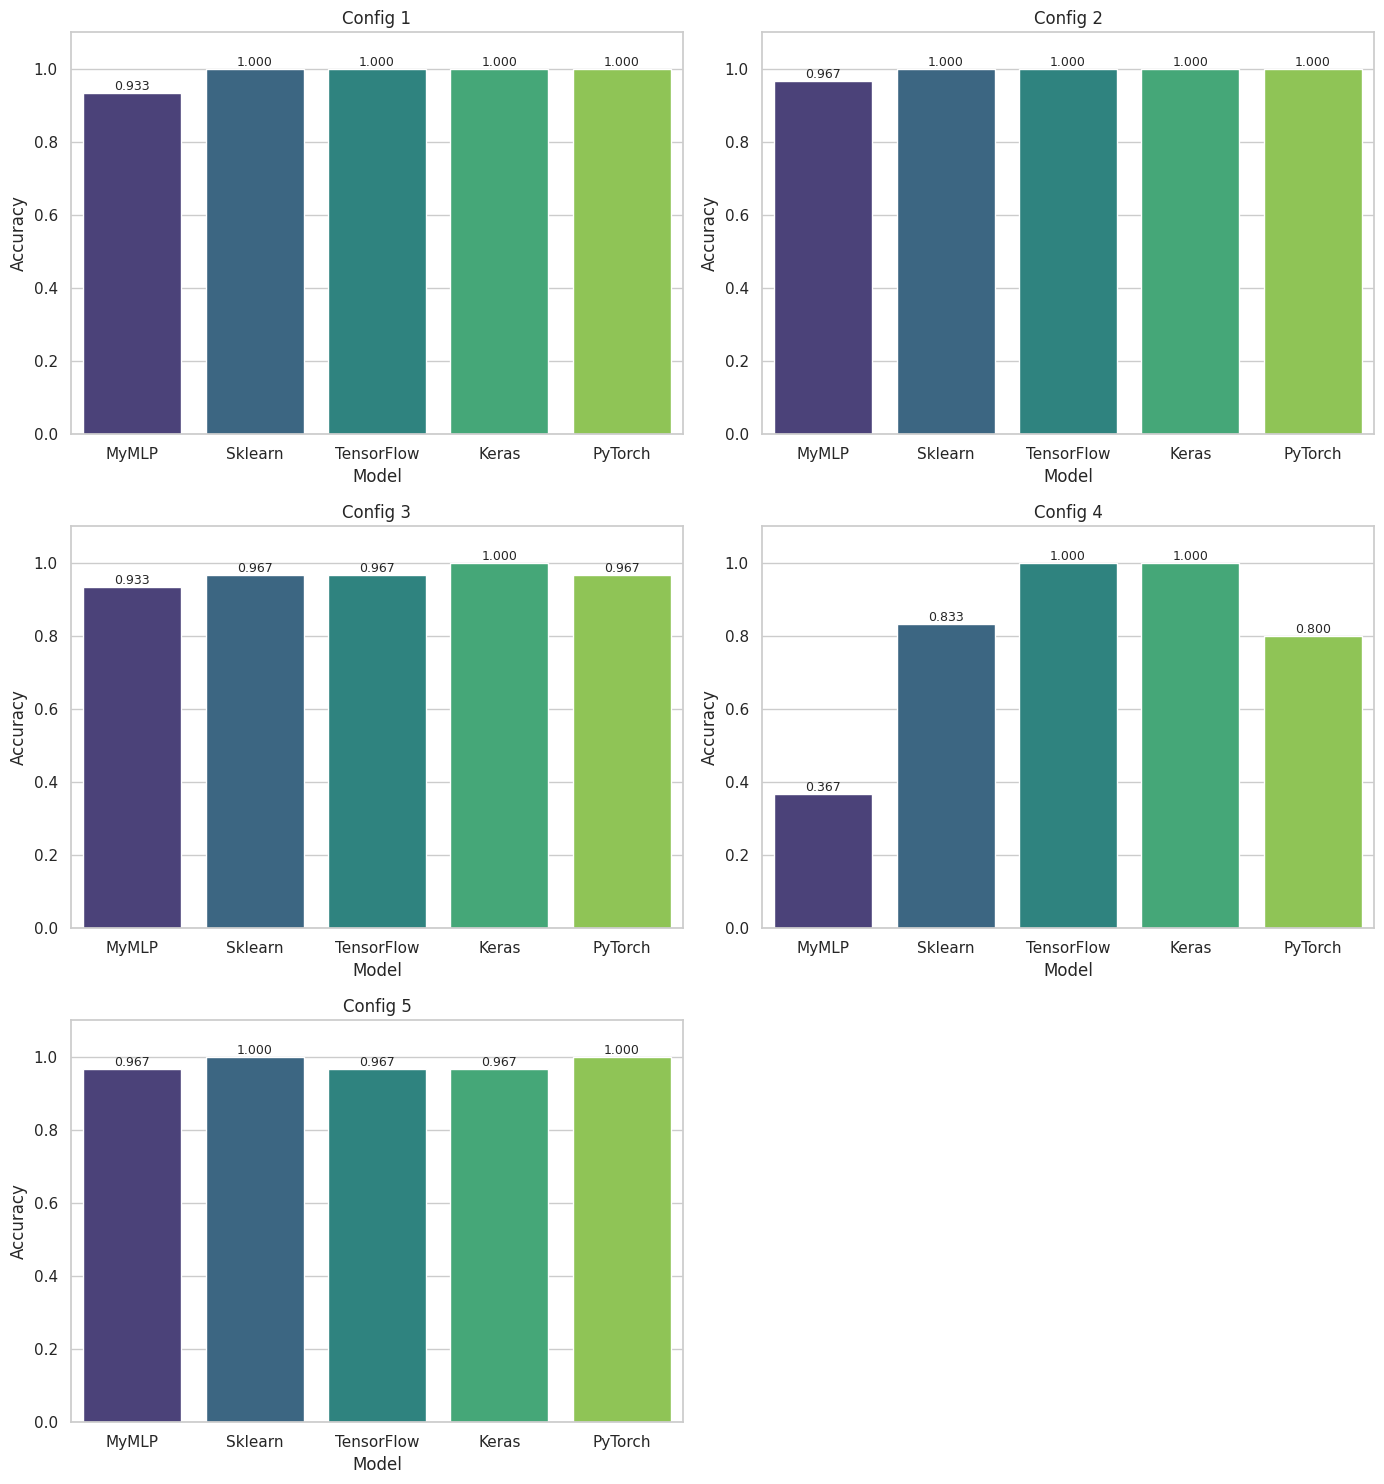

In [13]:
# Настройка стиля графиков
sns.set(style="whitegrid")

# Создаем отдельный график для каждой конфигурации
configs = sorted(df_cls_results['Config'].unique())
num_configs = len(configs)

fig, axes = plt.subplots(nrows=(num_configs + 1)//2, ncols=2, figsize=(14, num_configs * 3))
axes = axes.flatten()

for i, config in enumerate(configs):
    ax = axes[i]
    subset = df_cls_results[df_cls_results['Config'] == config]
    sns.barplot(x='Model', y='Accuracy', data=subset, ax=ax, palette='viridis')
    ax.set_title(f'Config {config}')
    ax.set_ylim(0, 1.1)  # Чтобы были видны значения до 1
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Model')

    # Подписываем значения над столбиками
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9)

# Убираем лишние пустые графики, если есть
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

В большинстве конфигураций для классификации наша реализация практически не уступает библиотечным. Также время инференса нашей модели быстрее библиотечных.

In [14]:
# Загрузка данных
data = fetch_california_housing()
X, y = data.data, data.target.reshape(-1, 1)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
# Конфигурации сетей
configs = [
    {"layers": [(8, ""), (16, "relu"), (1, "linear")], "lr": 0.01},
    {"layers": [(8, ""), (32, "relu"), (1, "linear")], "lr": 0.005},
    {"layers": [(8, ""), (16, "sigmoid"), (1, "linear")], "lr": 0.01},
    {"layers": [(8, ""), (64, "relu"), (1, "linear")], "lr": 0.001},
    {"layers": [(8, ""), (32, "sigmoid"), (1, "linear")], "lr": 0.01},
]

In [16]:
results = []

# MyMLP
for idx, cfg in enumerate(configs):
    print(f"\nMyMLP Config {idx+1}")
    mlp = MyMLP(cfg["layers"], learning_rate=cfg["lr"], task='regression', loss='mse')
    start = time.time()
    mlp.fit(X_train, y_train, epochs=50, batch_size=32)
    train_time = time.time() - start

    start = time.time()
    y_pred = mlp.predict(X_test)
    infer_time = time.time() - start

    mse = mean_squared_error(y_test, y_pred)
    print("MyMLP MSE:", mse)
    results.append(("MyMLP", idx+1, mse, train_time, infer_time))

# Sklearn MLPRegressor
for idx, cfg in enumerate(configs):
    print(f"\nSklearn Config {idx+1}")
    act = cfg["layers"][1][1]
    if act == 'sigmoid':
        act = 'logistic'  # sklearn expects 'logistic' not 'sigmoid'

    model = MLPRegressor(hidden_layer_sizes=[cfg["layers"][1][0]], learning_rate_init=cfg["lr"],
                         max_iter=50, activation=act, random_state=42)

    start = time.time()
    model.fit(X_train, y_train.ravel())
    train_time = time.time() - start

    start = time.time()
    y_pred = model.predict(X_test).reshape(-1, 1)
    infer_time = time.time() - start

    mse = mean_squared_error(y_test, y_pred)
    print("Sklearn MSE:", mse)
    results.append(("Sklearn", idx+1, mse, train_time, infer_time))

# Keras
for idx, cfg in enumerate(configs):
    print(f"\nKeras Config {idx+1}")
    model = keras.Sequential()
    model.add(keras.Input(shape=(8,)))
    model.add(keras.layers.Dense(cfg["layers"][1][0], activation=cfg["layers"][1][1]))
    model.add(keras.layers.Dense(1, activation='linear'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=cfg["lr"]),
                  loss='mse')

    start = time.time()
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    train_time = time.time() - start

    start = time.time()
    y_pred = model.predict(X_test)
    infer_time = time.time() - start

    mse = mean_squared_error(y_test, y_pred)
    print("Keras MSE:", mse)
    results.append(("Keras", idx+1, mse, train_time, infer_time))

# TensorFlow (без Keras)
for idx, cfg in enumerate(configs):
    print(f"\nTensorFlow Config {idx+1}")

    # Модель вручную
    layers_tf = []
    input_dim = 8
    for size, act in cfg["layers"][1:]:
        w = tf.Variable(tf.random.normal([input_dim, size], stddev=0.1))
        b = tf.Variable(tf.zeros([size]))
        layers_tf.append((w, b, act))
        input_dim = size

    def forward_tf(x):
        for w, b, activation in layers_tf:
            x = tf.matmul(x, w) + b
            if activation == 'relu':
                x = tf.nn.relu(x)
            elif activation == 'sigmoid':
                x = tf.nn.sigmoid(x)
        return x

    X_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)

    optimizer = tf.optimizers.Adam(learning_rate=cfg["lr"])

    start = time.time()
    for epoch in range(50):
        with tf.GradientTape() as tape:
            y_pred_tf = forward_tf(X_tf)
            loss = tf.reduce_mean(tf.square(y_pred_tf - y_tf))
        grads = tape.gradient(loss, [v for w, b, _ in layers_tf for v in (w, b)])
        optimizer.apply_gradients(zip(grads, [v for w, b, _ in layers_tf for v in (w, b)]))
    train_time = time.time() - start

    start = time.time()
    y_pred = forward_tf(tf.convert_to_tensor(X_test, dtype=tf.float32)).numpy()
    infer_time = time.time() - start

    mse = mean_squared_error(y_test, y_pred)
    print("TensorFlow MSE:", mse)
    results.append(("TensorFlow", idx+1, mse, train_time, infer_time))

# PyTorch
for idx, cfg in enumerate(configs):
    print(f"\nPyTorch Config {idx+1}")

    class PTModel(nn.Module):
        def __init__(self, hidden_size, activation):
            super().__init__()
            act_fn = nn.ReLU() if activation == "relu" else nn.Sigmoid()
            self.net = nn.Sequential(
                nn.Linear(8, hidden_size),
                act_fn,
                nn.Linear(hidden_size, 1)
            )

        def forward(self, x):
            return self.net(x)

    model = PTModel(cfg["layers"][1][0], cfg["layers"][1][1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg["lr"])

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)

    start = time.time()
    for epoch in range(50):
        y_pred = model(X_train_t)
        loss = criterion(y_pred, y_train_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_time = time.time() - start

    start = time.time()
    y_pred = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
    infer_time = time.time() - start

    mse = mean_squared_error(y_test, y_pred)
    print("PyTorch MSE:", mse)
    results.append(("PyTorch", idx+1, mse, train_time, infer_time))


MyMLP Config 1
MyMLP MSE: 0.4019330449314595

MyMLP Config 2
MyMLP MSE: 0.3743560871569134

MyMLP Config 3
MyMLP MSE: 0.4215425425547989

MyMLP Config 4
MyMLP MSE: 0.40301517307216894

MyMLP Config 5
MyMLP MSE: 0.4548673946529944

Sklearn Config 1


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Sklearn MSE: 0.24502640861858493

Sklearn Config 2


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Sklearn MSE: 0.2362283279822449

Sklearn Config 3


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Sklearn MSE: 0.2512743803551156

Sklearn Config 4


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Sklearn MSE: 0.23048062488885754

Sklearn Config 5


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Sklearn MSE: 0.23048262391544913

Keras Config 1
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
Keras MSE: 0.23542626062038388

Keras Config 2
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
Keras MSE: 0.22168922422843382

Keras Config 3
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
Keras MSE: 0.2190437878873616

Keras Config 4
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
Keras MSE: 0.21937307361179176

Keras Config 5
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
Keras MSE: 0.2201976297597485

TensorFlow Config 1
TensorFlow MSE: 0.33323157967519945

TensorFlow Config 2
TensorFlow MSE: 0.35535194223932254

TensorFlow Config 3
TensorFlow MSE: 0.406251089265576

TensorFlow Config 4
TensorFlow MSE: 0.5646196088306583

TensorFlow Config 5
TensorFlow MSE: 0.37747407650234416

PyTorch Config 1
PyTorch MSE: 0.333275516151599

PyTorch Config 2
PyTorch MSE: 0.3657434488694051

PyTorch Config 3
PyTorch MSE: 0.3858468886570866

PyTorch Config 4
PyTorch MSE: 0.6480415838811353

PyTorch Config 5
PyTorch MSE: 0.38944

In [17]:
df_results = pd.DataFrame(results, columns=["Model", "Config", "MSE", "Train Time (s)", "Infer Time (s)"])
df_results

,Model,Config,MSE,Train Time (s),Infer Time (s)
0,MyMLP,1,0.401933,1.525780,0.000854
1,MyMLP,2,0.374356,1.670128,0.000740
2,MyMLP,3,0.421543,3.707026,0.017538
3,MyMLP,4,0.403015,4.757210,0.004958
4,MyMLP,5,0.454867,3.140588,0.003086
5,Sklearn,1,0.245026,0.950279,0.001106
6,Sklearn,2,0.236228,1.122222,0.000903
7,Sklearn,3,0.251274,0.985748,0.002446
8,Sklearn,4,0.230481,2.419164,0.001431
9,Sklearn,5,0.230483,5.068788,0.018828


<ipython-input-18-ff594ac5aa2e>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MSE', data=subset, ax=ax, palette='viridis')
<ipython-input-18-ff594ac5aa2e>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MSE', data=subset, ax=ax, palette='viridis')
<ipython-input-18-ff594ac5aa2e>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MSE', data=subset, ax=ax, palette='viridis')
<ipython-input-18-ff594ac5aa2e>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be rem

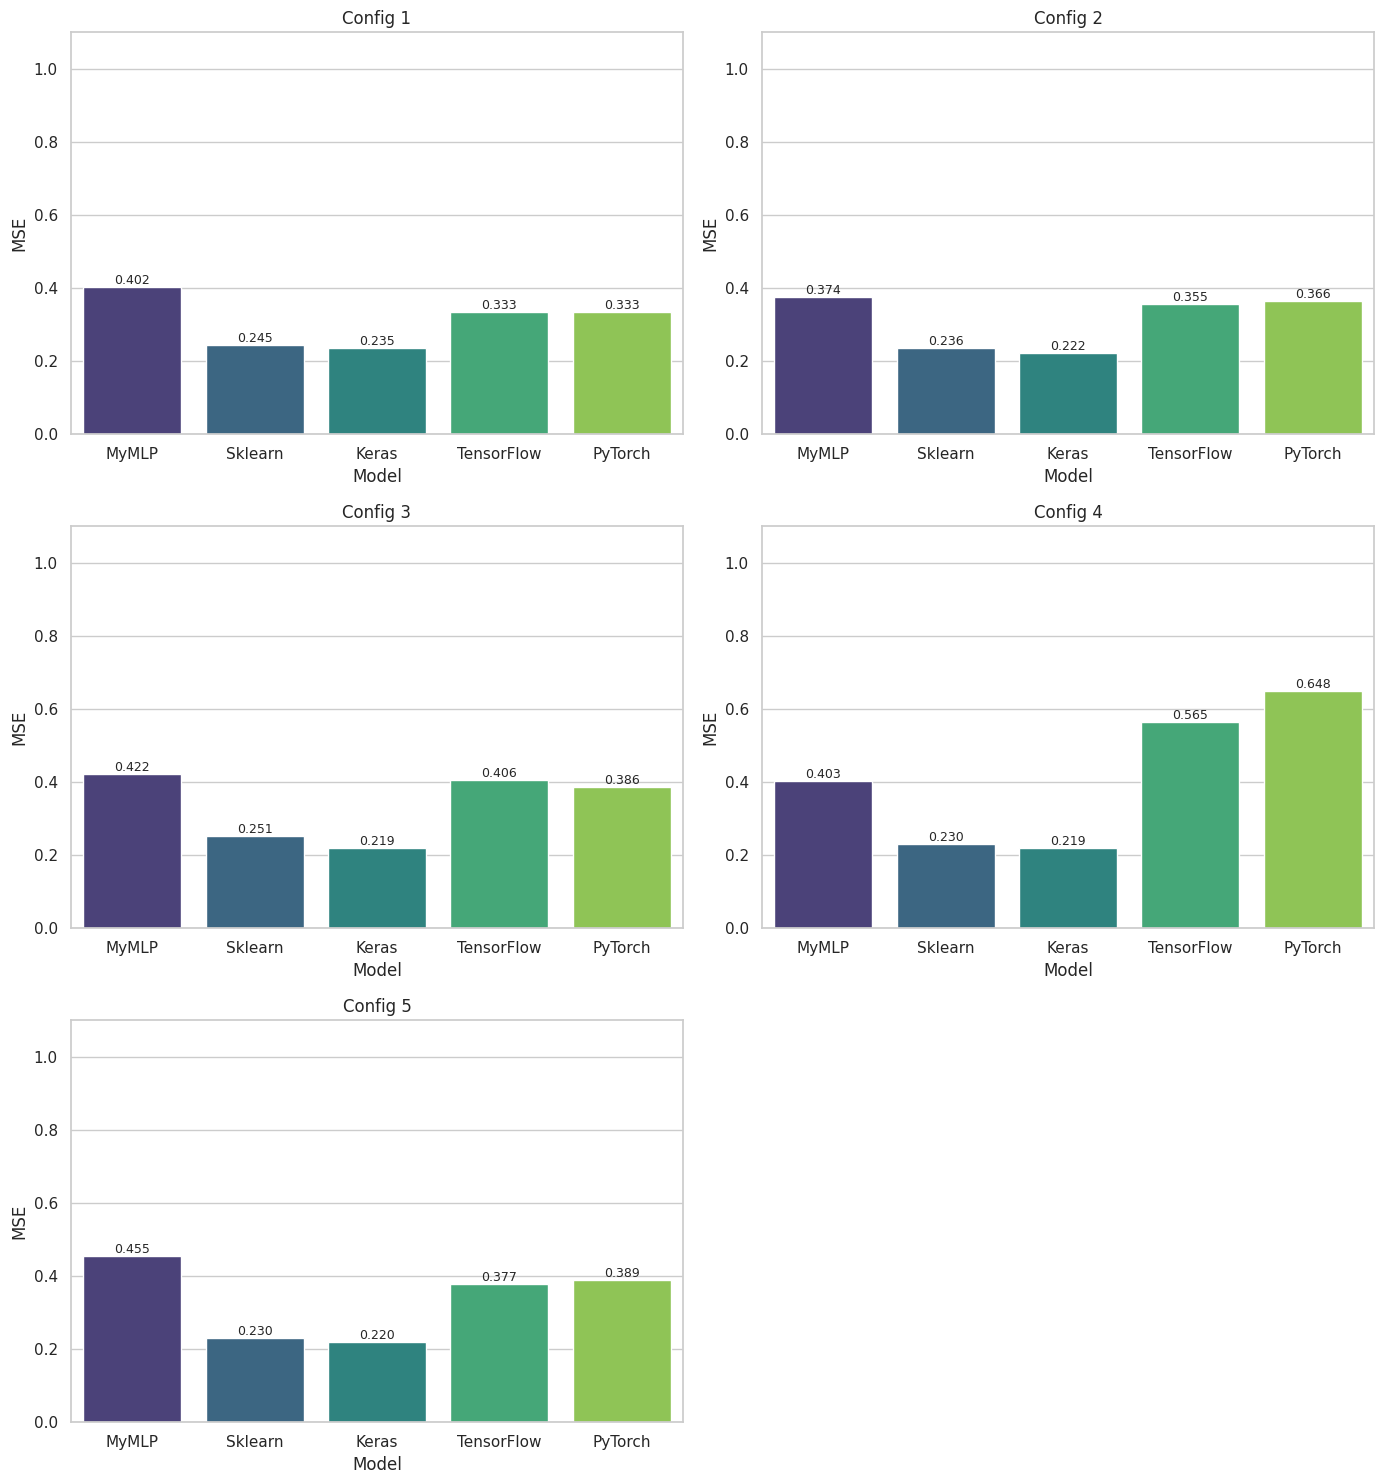

In [18]:
# Настройка стиля графиков
sns.set(style="whitegrid")

# Создаем отдельный график для каждой конфигурации
configs = sorted(df_results['Config'].unique())
num_configs = len(configs)

fig, axes = plt.subplots(nrows=(num_configs + 1)//2, ncols=2, figsize=(14, num_configs * 3))
axes = axes.flatten()

for i, config in enumerate(configs):
    ax = axes[i]
    subset = df_results[df_results['Config'] == config]
    sns.barplot(x='Model', y='MSE', data=subset, ax=ax, palette='viridis')
    ax.set_title(f'Config {config}')
    ax.set_ylim(0, 1.1)  # Чтобы были видны значения до 1
    ax.set_ylabel('MSE')
    ax.set_xlabel('Model')

    # Подписываем значения над столбиками
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9)

# Убираем лишние пустые графики, если есть
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Что касается регрессии, то в основном наша модель чуть слабее библиотечных реализаций. Однако в некоторызх случаях мы превосходим Tensorflow - кофнигурация 4, Keras - конфигурация 2 Наиболее лучшей тут выглядит sklearn.